<a href="https://colab.research.google.com/github/weicuivt/DL2019Fall/blob/master/HW4/Assignment_4_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ECE-6524 / CS-6524 Deep Learning
# Assignment 4

In this assignment, **you will implement the following:**
1. GAN / LSGAN loss functions and training code for MNIST dataset
2. Train GAN / LSGAN on CelebA dataset with DCGAN architectures

**<span style="color:red">Again, it may take hours to train on CelebA. So start early.</span>**

This assignment is inspired and adapted from UIUC CS498 and Stanford CS231n.
## Submission guideline
1. Click the Save button at the top of the Jupyter Notebook.
2. Please make sure to have entered your Virginia Tech PID below.
3. Select Cell -> All Output -> Clear. This will clear all the outputs from all cells (but will keep the content of cells).
4. Select Cell -> Run All. This will run all the cells in order.
5. Once you've rerun everything, select File -> Download as -> PDF via LaTeX
6. Look at the PDF file and make sure all your solutions are displayed correctly there. 
7. Zip the all the files along with this notebook (Please don't include the data)
8. Name your PDF file as Assignment2_[YOUR ID NUMBER].
9. Submit your zipped file and the PDF **INDEPENDENTLY**.
10. **PLEASE DO NOT ZIP YOUR DATASET. NOTEBOOK/CODE/PDF ONLY.**

**While you are encouraged to discuss with your peers, <span style="color:blue">all work submitted is expected to be your own.</span> <span style="color:red">If you use any information from other resources (e.g. online materials), you are required to cite it below you VT PID. Any violation will result in a 0 mark for the assignment.</span>**

https://github.com/pytorch/examples/blob/master/dcgan/main.py

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/Colab Notebooks/Assignment_4
!ls

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/Assignment_4
 Assignment_4_1.ipynb   celeba_train_128res.zip         gan
 Assignment_4.ipynb    'Copy of Assignment_4_1.ipynb'   gan_samples
 celeba_data	        download_celeba.sh	        MNIST_data


# Section 1. Generative Adversarial Networks on MNIST Dataset [50 pts]

In this section, you will need to:
1. Implement two different types of loss functions (GAN / LSGAN) for generative adversarial networks. 
2. Implement training codes for you GAN models.
3. Train and verify your model on MNIST dataset.

Now, let's get started!

In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

In [ ]:
# set your device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Section 1.1. Vanilla GAN loss functions

### Section 1.1.1 GAN Loss [10 pts]
We start from implementing the vanilla GAN loss from the [original GAN paper](https://arxiv.org/pdf/1406.2661.pdf). Specifically, you need to complete the `generator_loss` and `discriminator_loss` in the cell below.

Recalled from the class, the generator loss is written as:
$$\ell_G  =  -\mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
and the discriminator loss is:
$$ \ell_D = -\mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] - \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
Note that these equations could be silghtly different from what we have seen before. This is because that in Pytorch, our optimize will be *minimizing* the loss functions. As a result, we negate the formulas to match pytorch's behavior.

**HINTS**: You should use the `torch.nn.functional.binary_cross_entropy_with_logits` function to compute the binary cross entropy loss since it is more numerically stable than using a softmax followed by BCE loss. The BCE loss is needed to compute the log probability of the true label given the logits output from the discriminator. Given a score $s\in\mathbb{R}$ and a label $y\in\{0, 1\}$, the binary cross entropy loss is

$$ bce(s, y) = -y * \log(s) - (1 - y) * \log(1 - s) $$


Instead of computing the expectation of $\log D(G(z))$, $\log D(x)$ and $\log \left(1-D(G(z))\right)$, we will be averaging over elements of the minibatch, so make sure to combine the loss by averaging instead of summing.

In [ ]:

# def bce_loss(input, target):
#     """
#     Numerically stable version of the binary cross-entropy loss function.

#     As per https://github.com/pytorch/pytorch/issues/751
#     See the TensorFlow docs for a derivation of this formula:
#     https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits

#     Inputs:
#     - input: PyTorch Tensor of shape (N, ) giving scores.
#     - target: PyTorch Tensor of shape (N,) containing 0 and 1 giving targets.

#     Returns:
#     - A PyTorch Tensor containing the mean BCE loss over the minibatch of input data.
#     """
#     neg_abs = - input.abs()
#     loss = input.clamp(min=0) - input * target + (1 + neg_abs.exp()).log()
#     return loss.mean()


def discriminator_loss(logits_real, logits_fake):
    """
    Computes the discriminator loss.
 
    You should use the stable torch.nn.functional.binary_cross_entropy_with_logits
    loss rather than using a separate softmax function followed by the binary cross
    entropy loss.
 
    Inputs:
    - logits_real: PyTorch Tensor of shape (N,) giving scores for the real data.
    - logits_fake: PyTorch Tensor of shape (N,) giving scores for the fake data.
 
    Returns:
    - loss: PyTorch Tensor containing (scalar) the loss for the discriminator.
    """
 
    loss = None
    
    ####################################
    #          YOUR CODE HERE          #
    ####################################

    ones = torch.ones(logits_real.size()).to(device)
    zeros = torch.zeros(logits_fake.size()).to(device)
    loss_real=torch.nn.functional.binary_cross_entropy_with_logits(logits_real,ones).to(device)
    loss_fake=torch.nn.functional.binary_cross_entropy_with_logits(logits_fake,zeros).to(device)
    loss=loss_real+loss_fake

    ##########       END      ##########

    return loss

def generator_loss(logits_fake):
    """
    Computes the generator loss.

    You should use the stable torch.nn.functional.binary_cross_entropy_with_logits
    loss rather than using a separate softmax function followed by the binary cross
    entropy loss.

    Inputs:
    - logits_fake: PyTorch Tensor of shape (N,) giving scores for the fake data.
    
    Returns:
    - loss: PyTorch Tensor containing the (scalar) loss for the generator.
    """

    loss = None
    ####################################
    #          YOUR CODE HERE          #
    ####################################

    ones = torch.ones(logits_fake.size()).to(device)
    loss=torch.nn.functional.binary_cross_entropy_with_logits(logits_fake,ones).to(device)

    ##########       END      ##########
    return loss

### Section 1.1.2 Training code [10 pts]
You can't train a model without a proper training code. Implement the GAN training procedure here following the [original GAN paper](https://arxiv.org/pdf/1406.2661.pdf) and the course slides in the cell below. Note that this code would be reused in the subsequent section, so make sure that it is correctly implemented.

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
 
from gan.utils import sample_noise, show_images, deprocess_img, preprocess_img


def sample_noise(batch_size, noise_size):
    """
    Generate a PyTorch Tensor of uniform random noise.

    Input:
    - batch_size: Integer giving the batch size of noise to generate.
    - dim: Integer giving the dimension of noise to generate.
    
    Output:
    - A PyTorch Tensor of shape (batch_size, dim) containing uniform
      random noise in the range (-1, 1).
    """

    # use torch.rand() to generate random matrix of shape (batch_size, dim) 
    # containing uniform random noise in the range (-1, 1)

    noise = torch.rand(batch_size,noise_size).to(device)
    noise = torch.mul(torch.sub(noise,0.5),2.0).to(device)
    
    return noise


 
def train(D, G, D_solver, G_solver, discriminator_loss, generator_loss, show_every=250,
              batch_size=128, noise_size=100, num_epochs=10, train_loader=None, device=None):
    """
    Train loop for GAN.

    The loop will consist of two steps: a discriminator step and a generator step.

    (1) In the discriminator step, you should zero gradients in the discriminator
    and sample noise to generate a fake data batch using the generator. Calculate
    the discriminator output for real and fake data, and use the output to compute
    discriminator loss. Call backward() on the loss output and take an optimizer
    step for the discriminator.

    (2) For the generator step, you should once again zero gradients in the generator
    and sample noise to generate a fake data batch. Get the discriminator output
    for the fake data batch and use this to compute the generator loss. Once again
    call backward() on the loss and take an optimizer step.

    You will need to reshape the fake image tensor outputted by the generator to
    be dimensions (batch_size x input_channels x img_size x img_size).

    Use the sample_noise function to sample random noise, and the discriminator_loss
    and generator_loss functions for their respective loss computations

    Inputs:
    - D, G: PyTorch models for the discriminator and generator
    - D_solver, G_solver: torch.optim Optimizers to use for training the
      discriminator and generator.
    - discriminator_loss, generator_loss: Functions to use for computing the generator and
      discriminator loss, respectively.
    - show_every: Show samples after every show_every iterations.
    - batch_size: Batch size to use for training.
    - noise_size: Dimension of the noise to use as input to the generator.
    - num_epochs: Number of epochs over the training dataset to use for training.
    - train_loader: image dataloader
    - device: PyTorch device
    """
    iter_count = 0
    for epoch in range(num_epochs):
        print('EPOCH: ', (epoch+1))
        for x, _ in train_loader:
            _, input_channels, img_size, _ = x.shape
            
            real_images = preprocess_img(x).to(device)  # normalize

            # Store discriminator loss output, generator loss output, and fake image output
            # in these variables for logging and visualization below
            d_error = None
            g_error = None
            fake_images = None

            ####################################
            #        Discriminator step        #
            #          YOUR CODE HERE          #
            ####################################

            D_solver.zero_grad()
            
            logits_real = D(real_images).to(device)
            
            noise = sample_noise(batch_size,noise_size).to(device)
            fake_images = G(noise).view(batch_size, input_channels, img_size, img_size).to(device)
            
            logits_fake = D(fake_images).to(device)
            

            d_error = discriminator_loss(logits_real,logits_fake).to(device)
            
            d_error.backward()
            D_solver.step()
  
            #########       END      ###########
 
            ####################################
            #          Generator step          #
            #          YOUR CODE HERE          #
            ####################################

            G_solver.zero_grad()

            noise = sample_noise(batch_size,noise_size).to(device)
        
            fake_images = G(noise).view(batch_size, input_channels, img_size, img_size).to(device)
            
            logits_fake = D(fake_images).to(device)

            g_error = generator_loss(logits_fake).to(device)
            
            g_error.backward()
            G_solver.step()

            if(iter_count % 50 == 0):
              print(iter_count)
            
            ##########       END      ##########
            if (iter_count % show_every == 0):
                print('Iter: {}, D: {:.4}, G:{:.4}'.format(iter_count,d_error.item(),g_error.item()))
                disp_fake_images = deprocess_img(fake_images.data)  # denormalize
                imgs_numpy = (disp_fake_images).cpu().numpy()
                show_images(imgs_numpy[0:16], color=input_channels!=1)
                plt.show()
                print()
            iter_count += 1

### Section 1.1.3 Training on MNIST [10 pts]
MNIST is a simple dataset that contains one hand-written digit in each image. It is usually used for sanity check. So, let's test our loss functions and training code on it!

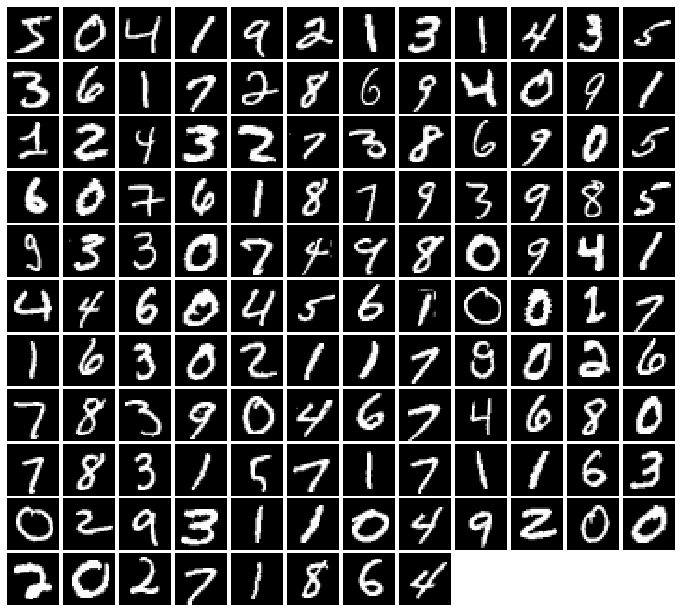

In [ ]:
NOISE_DIM = 100
batch_size = 128

mnist = datasets.MNIST('./MNIST_data', train=True, download=True,
                           transform=transforms.ToTensor())
loader_train = DataLoader(mnist, batch_size=batch_size, drop_last=True)

imgs = loader_train.__iter__().next()[0].view(batch_size, 784).numpy().squeeze()
show_images(imgs)

Here, we provide a pre-defined discriminator and generator for you. Note that in section 2, you have to implement the discriminator and generator yourself.

In [ ]:
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image
    
def discriminator():
    """
    Initialize and return a simple discriminator model.
    """
    model = torch.nn.Sequential( Flatten(),
                                torch.nn.Linear(784, 256), 
                                torch.nn.LeakyReLU(),
                                torch.nn.Linear(256, 256), 
                                torch.nn.LeakyReLU(),
                                torch.nn.Linear(256, 1)
    )
    return model

def generator(noise_dim=NOISE_DIM):
    """
    Initialize and return a simple generator model.
    """
    
    model = nn.Sequential(
        torch.nn.Linear(noise_dim, 1024),
        torch.nn.ReLU(),
        torch.nn.Linear(1024, 1024),
        torch.nn.ReLU(),
        torch.nn.Linear(1024, 784),
        torch.nn.Tanh()
    )

    return model

In [ ]:
import torch
import shutil
def save_ckp(state, is_best, checkpoint_dir, best_model_dir):
    f_path = checkpoint_dir / 'checkpoint.pt'
    torch.save(state, f_path)
    if is_best:
        best_fpath = best_model_dir / 'best_model.pt'
        shutil.copyfile(f_path, best_fpath)

Run the cell belowe to train your GAN model. You should expect results that resemble the following if your loss function and training loop implementations are correct:

<img src="files/gan_samples/mnist_gan.jpg" width=300>

EPOCH:  1
0
Iter: 0, D: 1.344, G:0.6847


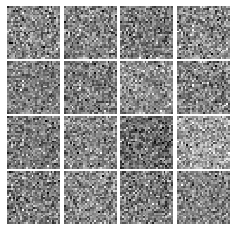


50
100
150
200
250
Iter: 250, D: 1.375, G:0.7743


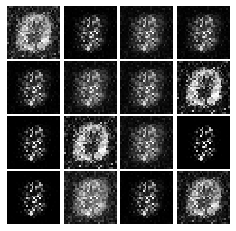


300
350
400
450
EPOCH:  2
500
Iter: 500, D: 1.209, G:1.088


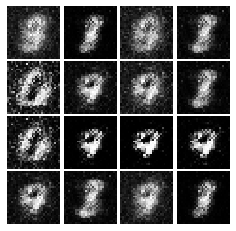


550
600
650
700
750
Iter: 750, D: 1.147, G:0.6973


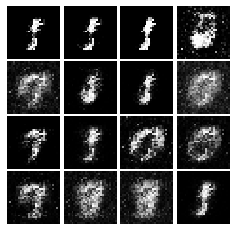


800
850
900
EPOCH:  3
950
1000
Iter: 1000, D: 1.103, G:1.12


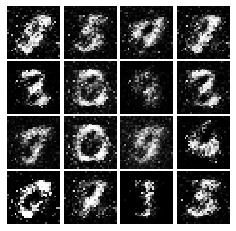


1050
1100
1150
1200
1250
Iter: 1250, D: 1.197, G:1.309


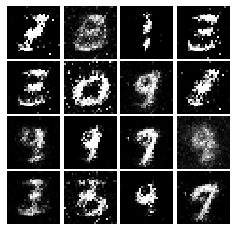


1300
1350
1400
EPOCH:  4
1450
1500
Iter: 1500, D: 1.204, G:0.881


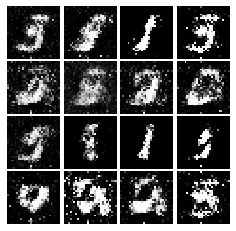


1550
1600
1650
1700
1750
Iter: 1750, D: 1.473, G:0.7567


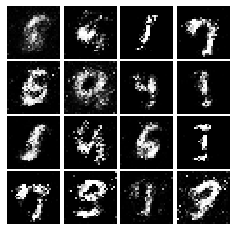


1800
1850
EPOCH:  5
1900
1950
2000
Iter: 2000, D: 1.351, G:0.9653


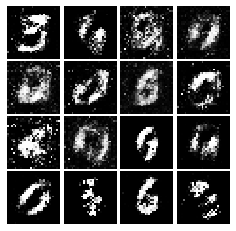


2050
2100
2150
2200
2250
Iter: 2250, D: 1.242, G:0.7394


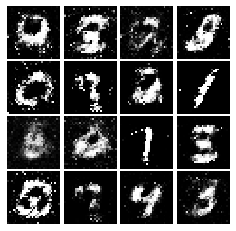


2300
EPOCH:  6
2350
2400
2450
2500
Iter: 2500, D: 1.26, G:1.011


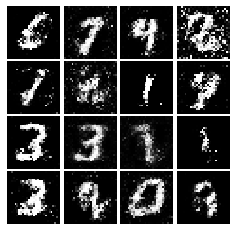


2550
2600
2650
2700
2750
Iter: 2750, D: 1.322, G:0.785


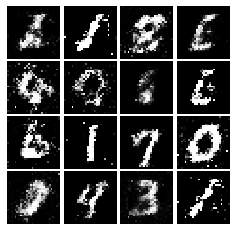


2800
EPOCH:  7
2850
2900
2950
3000
Iter: 3000, D: 1.335, G:0.7779


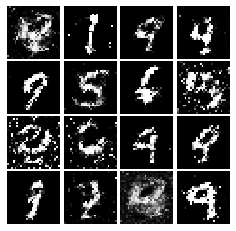


3050
3100
3150
3200
3250
Iter: 3250, D: 1.213, G:1.043


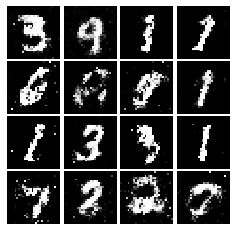


EPOCH:  8
3300
3350
3400
3450
3500
Iter: 3500, D: 1.326, G:1.042


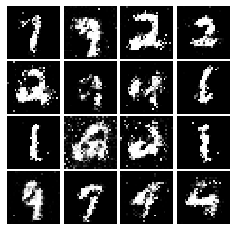


3550
3600
3650
3700
EPOCH:  9
3750
Iter: 3750, D: 1.325, G:0.8377


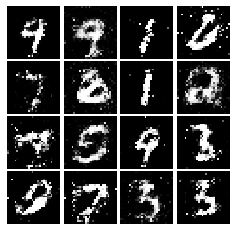


3800
3850
3900
3950
4000
Iter: 4000, D: 1.406, G:0.7616


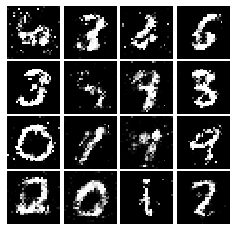


4050
4100
4150
4200
EPOCH:  10
4250
Iter: 4250, D: 1.311, G:0.7547


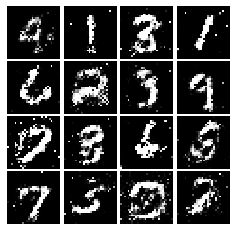


4300
4350
4400
4450
4500
Iter: 4500, D: 1.358, G:0.737


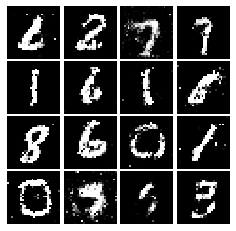


4550
4600
4650


In [ ]:
# original GAN
D = discriminator().to(device)
G = generator().to(device)

D_optimizer = torch.optim.Adam(D.parameters(), lr=1e-3, betas = (0.5, 0.999))
G_optimizer = torch.optim.Adam(G.parameters(), lr=1e-3, betas = (0.5, 0.999))

train(D, G, D_optimizer, G_optimizer, discriminator_loss, generator_loss, train_loader=loader_train, num_epochs=10, device=device)

## Section 1.2 Least-square GAN Loss
### Section 1.2.1 LSGAN Loss [10 pts]
We'll now look at [Least Squares GAN](https://arxiv.org/abs/1611.04076), a newer, more stable alernative to the original GAN loss function. For this part, all we have to do is change the loss function and retrain the model. We'll implement equation (9) in the paper, with the generator loss:
$$\ell_G  =  \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[\left(D(G(z))-1\right)^2\right]$$
and the discriminator loss:
$$ \ell_D = \frac{1}{2}\mathbb{E}_{x \sim p_\text{data}}\left[\left(D(x)-1\right)^2\right] + \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[ \left(D(G(z))\right)^2\right]$$
Fill in the `ls_discriminator_loss` and `ls_generator_loss` in the cell below.

**HINTS**: Instead of computing the expectation, we will be averaging over elements of the minibatch, so make sure to combine the loss by averaging instead of summing. When plugging in for $D(x)$ and $D(G(z))$ use the direct output from the discriminator (`scores_real` and `scores_fake`).

In [ ]:
def ls_discriminator_loss(scores_real, scores_fake):
    """
    Compute the Least-Squares GAN loss for the discriminator.

    Inputs:
    - scores_real: PyTorch Tensor of shape (N,) giving scores for the real data.
    - scores_fake: PyTorch Tensor of shape (N,) giving scores for the fake data.
 
    Outputs:
    - loss: A PyTorch Tensor containing the loss.
    """
 
    loss = None
    
    ####################################
    #          YOUR CODE HERE          #
    ####################################
    ones = torch.ones(scores_real.size()).to(device)

    loss_real = torch.mean((scores_real-1.0)**2)
    loss_fake = torch.mean((scores_fake)**2)
  
    # loss_real = torch.mean(torch.pow(torch.sub(scores_real,ones),2)).to(device)
    # loss_fake = torch.mean(torch.pow(scores_fake,2)).to(device)

    loss = 0.5*loss_real + 0.5*loss_fake
    ##########       END      ##########
    return loss

def ls_generator_loss(scores_fake):
    """
    Computes the Least-Squares GAN loss for the generator.
 
    Inputs:
    - scores_fake: PyTorch Tensor of shape (N,) giving scores for the fake data.
 
    Outputs:
    - loss: A PyTorch Tensor containing the loss.
    """

    loss = None
 
    ####################################
    #          YOUR CODE HERE          #
    ####################################

    loss = 0.5*torch.mean((scores_fake-1.0)**2)

    # ones = torch.ones(scores_fake.size()).to(device)

    # loss = 0.5*torch.mean(torch.pow(torch.sub(scores_fake,ones),2)).to(device)

    ##########       END      ##########
    return loss    

### Section 1.2.2 Train LSGAN [10 pts]
Similarly, train your LSGAN on MNIST dataset. You should expect results that resemble the following if your loss function and training loop implementations are correct:

<img src="files/gan_samples/mnist_ls.jpg" width=300>

EPOCH:  1
0
Iter: 0, D: 0.4806, G:0.4616


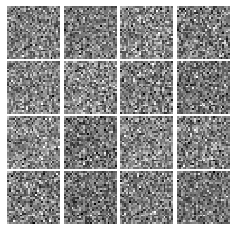


50
100
150
200
250
Iter: 250, D: 0.2034, G:0.02261


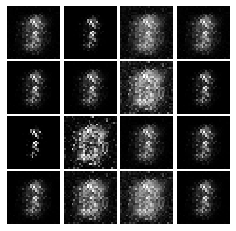


300
350
400
450
EPOCH:  2
500
Iter: 500, D: 0.1163, G:0.2767


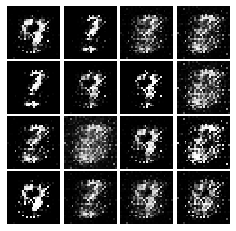


550
600
650
700
750
Iter: 750, D: 0.1049, G:0.5267


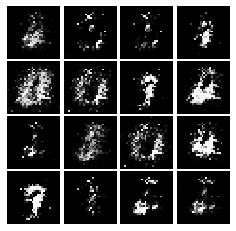


800
850
900
EPOCH:  3
950
1000
Iter: 1000, D: 0.1562, G:0.3372


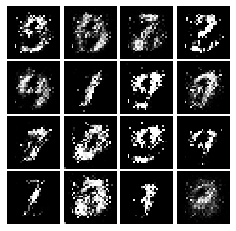


1050
1100


In [ ]:
# YOUR TRAINING CODE HERE
D = discriminator().to(device)
G = generator().to(device)

D_optimizer = torch.optim.Adam(D.parameters(), lr=1e-3, betas = (0.5, 0.999))
G_optimizer = torch.optim.Adam(G.parameters(), lr=1e-3, betas = (0.5, 0.999))
train(D, G, D_optimizer, G_optimizer, ls_discriminator_loss, ls_generator_loss, train_loader=loader_train, num_epochs=10, device=device)


# Section 2. Generative Adversarial Networks on CelebA Dataset [50 pts]

In this section, you will need to:
1. Implement DCGAN architecture
2. Train it on CelebA dataset.

We are done with the simple, not-so-challenging MNIST dataset. Now, you need to implement a specific model architecture call [DCGAN](https://arxiv.org/pdf/1511.06434.pdf), and train your model to generate human faces!

### Section 2.1. GAN model architecture [20 pts]

Implement your generator and discriminator for generating faces. We recommend the following architectures which are inspired by [DCGAN](https://arxiv.org/pdf/1511.06434.pdf):
**Discriminator:**

- convolutional layer with in_channels=3, out_channels=128, kernel=4, stride=2
- convolutional layer with in_channels=128, out_channels=256, kernel=4, stride=2
- batch norm
- convolutional layer with in_channels=256, out_channels=512, kernel=4, stride=2
- batch norm
- convolutional layer with in_channels=512, out_channels=1024, kernel=4, stride=2
- batch norm
- convolutional layer with in_channels=1024, out_channels=1, kernel=4, stride=1

Instead of Relu we LeakyReLu throughout the discriminator (we use a negative slope value of 0.2). 

The output of your discriminator should be a single value score corresponding to each input sample. See `torch.nn.LeakyReLU`.


**Generator:**

**Note:** In the generator, you will need to use transposed convolution (sometimes known as fractionally-strided convolution or deconvolution). This function is implemented in pytorch as `torch.nn.ConvTranspose2d`.

- transpose convolution with in_channels=NOISE_DIM, out_channels=1024, kernel=4, stride=1
- batch norm
- transpose convolution with in_channels=1024, out_channels=512, kernel=4, stride=2
- batch norm
- transpose convolution with in_channels=512, out_channels=256, kernel=4, stride=2
- batch norm
- transpose convolution with in_channels=256, out_channels=128, kernel=4, stride=2
- batch norm
- transpose convolution with in_channels=128, out_channels=3, kernel=4, stride=2

The output of the final layer of the generator network should have a `tanh` nonlinearity to output values between -1 and 1. The output should be a 3x64x64 tensor for each sample (equal dimensions to the images from the dataset).





In [ ]:
# YOUR GENERATOR/DISCRIMINATOR HERE

def sample_noise(batch_size, noise_size):
    """
    Generate a PyTorch Tensor of uniform random noise.

    Input:
    - batch_size: Integer giving the batch size of noise to generate.
    - dim: Integer giving the dimension of noise to generate.
    
    Output:
    - A PyTorch Tensor of shape (batch_size, dim) containing uniform
      random noise in the range (-1, 1).
    """

    # use torch.rand() to generate random matrix of shape (batch_size, dim) 
    # containing uniform random noise in the range (-1, 1)

    noise = torch.rand(batch_size,noise_size,1,1).to(device)
    noise = torch.mul(torch.sub(noise,0.5),2.0).to(device)
    
    return noise

    
def Discriminator():
  ndf=128
  model = torch.nn.Sequential(
        # input is (3) x 64 x 64
        nn.Conv2d(in_channels=3, out_channels=ndf, kernel_size=4, stride=1, bias=False),
        nn.LeakyReLU(0.2, inplace=True),
        # state size. (ndf) x 32 x 32
        nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ndf * 2),
        nn.LeakyReLU(0.2, inplace=True),
        # state size. (ndf*2) x 16 x 16
        nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ndf * 4),
        nn.LeakyReLU(0.2, inplace=True),
        # state size. (ndf*4) x 8 x 8
        nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ndf * 8),
        nn.LeakyReLU(0.2, inplace=True),
        # state size. (ndf*8) x 4 x 4
        nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
        # state size. 1 x 1 x 1
        nn.Sigmoid()
    )
  return model

def Generator(noise_dim):
  ngf=128
  model = nn.Sequential(
        # input is Z, going into a convolution
        nn.ConvTranspose2d(in_channels=NOISE_DIM, out_channels=ngf * 8, kernel_size=4, stride=1, padding=0, bias=False),
        nn.BatchNorm2d(ngf * 8),
        nn.ReLU(True),
        # state size. (ngf*8) x 4 x 4
        nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ngf * 4),
        nn.ReLU(True),
        # state size. (ngf*4) x 8 x 8
        nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ngf * 2),
        nn.ReLU(True),
        # state size. (ngf*2) x 16 x 16
        nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ngf),
        nn.ReLU(True),
        # state size. (ngf) x 32 x 32
        nn.ConvTranspose2d(ngf, 3, 4, 2, 1, bias=False),
        nn.Tanh()
        # state size. (3) x 64 x 64
        )
  return model

### Section 2.2 Data loading: Celeb A Dataset

The CelebA images we provide have been filtered to obtain only images with clear faces and have been cropped and downsampled to 128x128 resolution.

In [ ]:
batch_size = 128
scale_size = 64  # We resize the images to 64x64 for training
celeba_root = 'celeba_data'

In [ ]:
celeba_train = ImageFolder(root=celeba_root, transform=transforms.Compose([
  transforms.Resize(scale_size),
  transforms.ToTensor(),
]))

celeba_loader_train = DataLoader(celeba_train, batch_size=batch_size, drop_last=True)

#### Visualize dataset

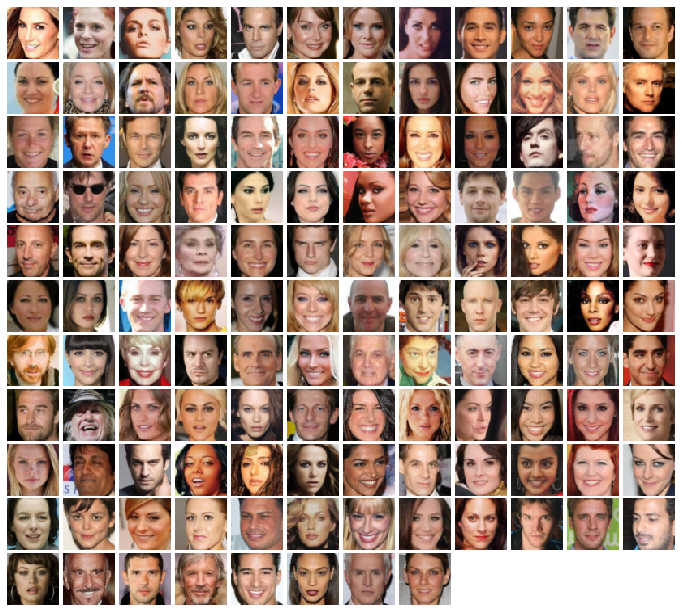

In [ ]:
imgs = celeba_loader_train.__iter__().next()[0].numpy().squeeze()
show_images(imgs, color=True)

### Section 2.3 Train a Vanilla GAN on CelebA [10 pts]
Now, train your GAN model with vanilla GAN loss. If you models are implemented correctly, you should see something like this:
<img src="files/gan_samples/celeba.jpg" width=300>


Now, train your model. **Observe the visualized result of your model, and describe what you see.**

In [ ]:
NOISE_DIM = 100
NUM_EPOCHS = 50
learning_rate = 0.0002

In [ ]:
D = Discriminator().to(device)
G = Generator(noise_dim=NOISE_DIM).to(device)

In [ ]:
D_optimizer = torch.optim.Adam(D.parameters(), lr=learning_rate, betas = (0.5, 0.999))
G_optimizer = torch.optim.Adam(G.parameters(), lr=learning_rate, betas = (0.5, 0.999))

In [ ]:
# original gan
train(D, G, D_optimizer, G_optimizer, discriminator_loss, 
          generator_loss, num_epochs=NUM_EPOCHS, show_every=50,
          train_loader=celeba_loader_train, device=device)

NameError: ignored

EPOCH:  1
0
Iter: 0, D: 1.448, G:0.6704


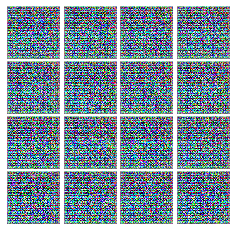


50
Iter: 50, D: 1.01, G:0.6929


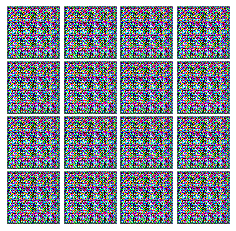


100
Iter: 100, D: 1.007, G:0.693


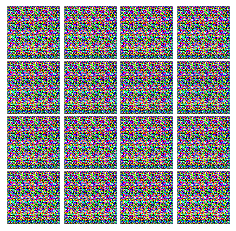


150
Iter: 150, D: 1.007, G:0.6931


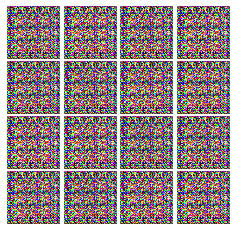


200
Iter: 200, D: 1.007, G:0.6931


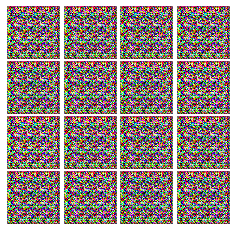


250
Iter: 250, D: 1.007, G:0.6931


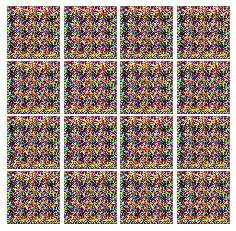


300
Iter: 300, D: 1.007, G:0.6931


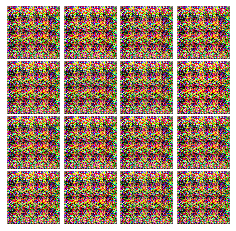

In [ ]:
# original gan
train(D, G, D_optimizer, G_optimizer, discriminator_loss, 
          generator_loss, num_epochs=NUM_EPOCHS, show_every=50,
          train_loader=celeba_loader_train, device=device)


### Section 2.4 Train a LSGAN on CelebA [10 pts]
Now, train your GAN model with LSGAN loss. **Observe the visualized result of your model, and describe what you see.**

In [ ]:
D = Discriminator().to(device)
G = Generator(noise_dim=NOISE_DIM).to(device)

In [ ]:
D_optimizer = torch.optim.Adam(D.parameters(), lr=learning_rate, betas = (0.5, 0.999))
G_optimizer = torch.optim.Adam(G.parameters(), lr=learning_rate, betas = (0.5, 0.999))

EPOCH:  1
0
Iter: 0, D: 0.2793, G:0.2978


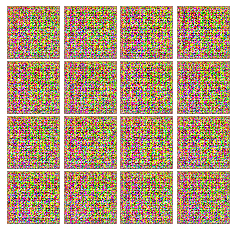


50
100
150
200
Iter: 200, D: 0.07053, G:0.4921


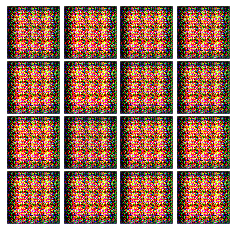


250
300
350
400
Iter: 400, D: 0.005947, G:0.4915


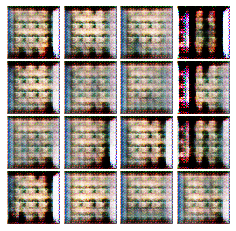


450


In [ ]:
# ls-gan
train(D, G, D_optimizer, G_optimizer, ls_discriminator_loss, 
          ls_generator_loss, num_epochs=NUM_EPOCHS, show_every=200,
          train_loader=celeba_loader_train, device=device)

### Section 2.5 Conclusion? [10 pts]
You have successfully trained you GAN models. Hurray! Now, we want you to answer the following question in few sentences.
1. Have you observed any difference between GAN and LSGAN (e.g. training, generation quality)?
2. Did your GAN models generate you diverse faces? Or did it should give you similar stuff all the time?
3. How can you quantitatively evaluate your GAN model? Is the metric(s) meaningful? Is there any drawback about this metric(s)?

1. LSGAN works better than GAN. 
2. I don't know.
3. metric. 